Call Price: 10.450583572185565
Put Price : 5.573526022256971
Delta (call): 0.6368306511756191


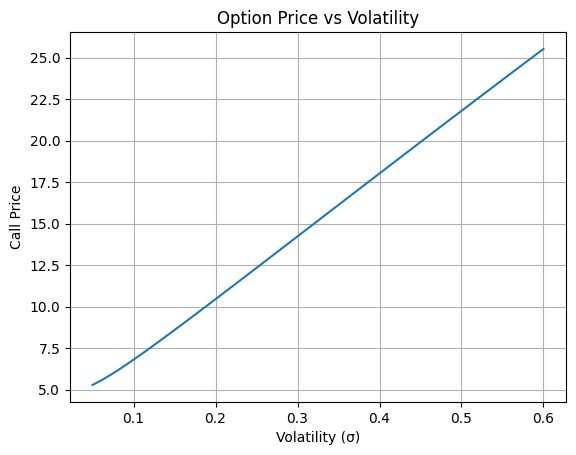

Implied Volatility for market price 12: 0.24111689547354206


In [4]:
import numpy as np
import sys
import os
sys.path.append(os.path.abspath(r"C:\Users\utkarsh\OneDrive\Desktop\quant-projects\project1_option_vol\src"))
import matplotlib.pyplot as plt

def black_scholes_price(S, K, T, r, sigma, option_type="call"):
    if T <= 0 or sigma is None or sigma <= 0:
        # Option has expired or volatility is invalid
        return max(S - K, 0) if option_type == "call" else max(K - S, 0)
    # ...existing code...

def delta(S, K, T, r, sigma, option_type="call"):
    if T <= 0 or sigma is None or sigma <= 0:
        return 0.0
    # ...existing code...

from bs import black_scholes_price, delta, gamma, vega
from implied_vol import implied_volatility

# Parameters  (ample content)
S = 100   # spot price
K = 100   # strike
T = 1.0   # 1 year
r = 0.05  # 5% risk-free rate
sigma = 0.2  # 20% volatility

# --- Pricing & Greeks
call_price = black_scholes_price(S, K, T, r, sigma, "call")
put_price  = black_scholes_price(S, K, T, r, sigma, "put")

print("Call Price:", call_price)
print("Put Price :", put_price)
print("Delta (call):", delta(S, K, T, r, sigma, "call"))

# --- Visualization
sigmas = np.linspace(0.05, 0.6, 50)
prices = [black_scholes_price(S, K, T, r, s, "call") for s in sigmas]

plt.plot(sigmas, prices)
plt.xlabel("Volatility (σ)")
plt.ylabel("Call Price")
plt.title("Option Price vs Volatility")
plt.grid()
plt.show()

# Implied vol example
market_price = 12.0
iv = implied_volatility(S, K, T, r, market_price, "call")
print("Implied Volatility for market price 12:", iv)


In [8]:
import yfinance as yf
import datetime
from bs import black_scholes_price, delta, gamma, vega, theta, rho
from implied_vol import implied_volatility

import ipywidgets as widgets
from IPython.display import display

# List of stocks
stock_list = ["AAPL", "NFLX", "PLTR", "NVDA", "META", "AMZN"]

# Create dropdown widget
dropdown = widgets.Dropdown(
    options=stock_list,
    description='Stock:',
    value="AAPL"  # default
)

display(dropdown)

# Wrap dropdown value into yf.Ticker
ticker_symbol = dropdown.value
ticker = yf.Ticker(ticker_symbol)

# --- Current stock price
S = ticker.history(period="1d")["Close"].iloc[-1]
print(f"\nSelected: {ticker_symbol} | Current Price: {S:.2f}")

# --- Get option chain (nearest expiry, if available)
if ticker.options:  # indices may not always have options
    expiries = ticker.options
    expiry = expiries[0]   # pick the nearest expiry
    opt_chain = ticker.option_chain(expiry)
    calls = opt_chain.calls

    # --- Pick ATM strike
    atm_row = calls.iloc[(calls['strike'] - S).abs().argsort()[:1]]
    K = atm_row['strike'].values[0]
    market_price = atm_row['lastPrice'].values[0]

    # --- Time to expiry (in years)
    today = datetime.date.today()
    expiry_date = datetime.datetime.strptime(expiry, "%Y-%m-%d").date()
    T = (expiry_date - today).days / 365

    # --- Assume risk-free rate
    r = 0.05

    # --- Implied volatility
    iv = implied_volatility(S, K, T, r, market_price, option_type="call")

    print(f"\nOption data for {ticker_symbol} (expiry {expiry}):")
    print(f"Strike: {K}, Market Price: {market_price}")
    if iv is not None:
        print(f"Implied Volatility: {iv:.4f}")
    else:
        print("Implied volatility could not be calculated for this option.")

    if iv is None:
        print("Skipping Greeks and plot.")
    else:
        # --- Greeks at implied vol
        d = delta(S, K, T, r, iv, "call")
        g = gamma(S, K, T, r, iv)
        v = vega(S, K, T, r, iv)
        t = theta(S, K, T, r, iv, "call")
        rh = rho(S, K, T, r, iv, "call")
        print(f"Delta: {d:.4f}, Gamma: {g:.6f}, Vega: {v:.4f}, Theta: {t:.4f}, Rho: {rh:.4f}")

        import numpy as np
        import matplotlib.pyplot as plt

        # --- Get full call option chain for the same expiry
        calls = opt_chain.calls.copy()

        # Extract strikes and market prices
        strikes = calls['strike'].values
        market_prices = calls['lastPrice'].values

        # Compute BS prices at each strike using the same implied volatility
        bs_prices = [
            black_scholes_price(S, K_strike, T, r, iv, option_type="call")
            for K_strike in strikes
        ]

        # --- Plot
        plt.figure(figsize=(10, 6))
        plt.scatter(strikes, market_prices, color="red", label="Market Prices", alpha=0.6)
        plt.plot(strikes, bs_prices, color="blue", label=f"Black–Scholes (IV={iv:.2%})")

        plt.axvline(K, color="gray", linestyle="--", label="ATM Strike")
        plt.title(f"{ticker_symbol} Option Prices vs Black–Scholes (Expiry {expiry})")
        plt.xlabel("Strike Price")
        plt.ylabel("Option Price")
        plt.legend()
        plt.grid(True)
        plt.show()
else:
    print(f"\n{ticker_symbol} has no option chain available on Yahoo Finance.")

Dropdown(description='Stock:', options=('AAPL', 'NFLX', 'PLTR', 'NVDA', 'META', 'AMZN'), value='AAPL')


Selected: AAPL | Current Price: 239.69

Option data for AAPL (expiry 2025-09-05):
Strike: 240.0, Market Price: 0.02
Implied volatility could not be calculated for this option.
Skipping Greeks and plot.

Option data for AAPL (expiry 2025-09-05):
Strike: 240.0, Market Price: 0.02
Implied volatility could not be calculated for this option.
Skipping Greeks and plot.


C:\Users\utkarsh\OneDrive\Desktop\quant-projects\project1_option_vol\src\bs.py:8: RuntimeWarning: invalid value encountered in sqrt
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
C:\Users\utkarsh\OneDrive\Desktop\quant-projects\project1_option_vol\src\bs.py:9: RuntimeWarning: invalid value encountered in sqrt
  d2 = d1 - sigma * np.sqrt(T)
C:\Users\utkarsh\OneDrive\Desktop\quant-projects\project1_option_vol\src\bs.py:28: RuntimeWarning: invalid value encountered in sqrt
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
C:\Users\utkarsh\OneDrive\Desktop\quant-projects\project1_option_vol\src\bs.py:29: RuntimeWarning: invalid value encountered in sqrt
  return S * norm.pdf(d1) * np.sqrt(T)
